# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [3]:
%cuda_context_handler gpu_ctx

Rossby utils

In [4]:
# %%
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
sys.path.insert(0, "/home/florianb/havvarsel/multilevelDA/")
from utils.RossbyInit import *
from utils.WindPerturb import *
from utils.RossbyAnalysis import *
from utils.RossbyEnsembleInit import *


## Data Assimilation


In [5]:
def imshow3(etahuhv):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [6]:
def imshow3var(est_var):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(est_var[0], vmin=0.0, vmax=0.00025, cmap="Reds")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(est_var[1], vmin=0, vmax=1, cmap="Reds")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(est_var[2], vmin=0, vmax=1, cmap="Reds")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    # fig.suptitle("ML variance", y=0.9)

    return fig, axs

In [7]:
wind_N = 100
t_splits = 26

KLSampler = KarhunenLoeve_Sampler(t_splits + 3, wind_N, decay=1.15, scaling=0.9)
wind_weight = wind_bump(KLSampler.N,KLSampler.N)

In [8]:
vars_file = "/home/florianb/havvarsel/multilevelDA/scripts/OutputVarianceLevels/2023-02-24T16_29_26_Rossby/vars.npy"
diff_vars_file = "/home/florianb/havvarsel/multilevelDA/scripts/OutputVarianceLevels/2023-02-24T16_29_26_Rossby/diff_vars.npy"

In [9]:
ls = [6, 7, 8, 9, 10]

In [10]:
T = 125000
T_forecast = 12500

In [11]:
rossbyAnalysis = RossbyAnalysis(ls, vars_file, diff_vars_file)
ML_Nes = rossbyAnalysis.optimal_Ne(tau=2.0*1e-7)
ML_Nes

array([5193,  189,   51,   14,    6], dtype=int32)

In [12]:
def generate_truth():
    data_args = initLevel(ls[-1])
    true_wind = wind_sample(KLSampler, T + T_forecast, wind_weight=wind_weight, wind_speed=0.0)
    truth = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=true_wind)

    return truth

def generate_obs_from_truth(truth, Hy, Hx, R):
    true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

    Hfield = np.zeros((truth.ny,truth.nx))
    
    Hfield[Hy,Hx] = 1.0

    obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

    return obs

#ML_ensemble = initMLensemble(gpu_ctx, ls, ML_Nes, KLSampler, wind_weight, T + T_forecast, 0.0)


Hy, Hx = 600, 800
#R = [0.0001, 0.01, 0.01]
R = [0,0,0]

### Truth

[-0.00107057 -0.00422809  0.0947276 ]


Text(0.5, 0.85, 'Truth')

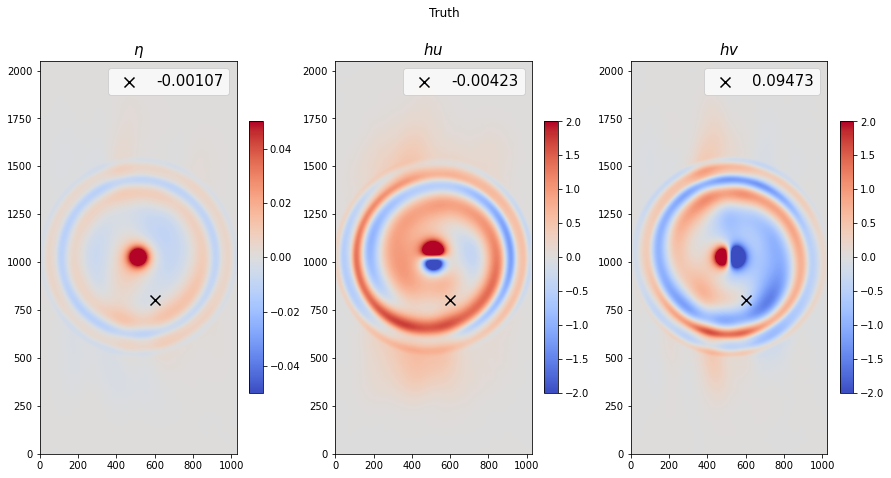

In [13]:
truth = generate_truth()
truth.step(T)
obs = generate_obs_from_truth(truth, Hy, Hx, R)

print(obs)

fig, axs = imshow3(truth.download())
axs[0].scatter(Hy,Hx, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hy, Hx, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hy, Hx, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)

In [14]:
# obs = np.array([-0.00148674, -0.5303819,  0.03913767])

### Analyse ML estimators

In [15]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
from gpuocean.dataassimilation import MLEnKFOcean

In [16]:
# ML_ensemble = initMLensemble(gpu_ctx, ls, ML_Nes, KLSampler, wind_weight, T + T_forecast, 0.0)
# MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

# MLOceanEnsemble.step(T)

# timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
# np.save(str(timestamp)+"dumpMLensemble0", MLOceanEnsemble.download()[0])
# for l in range(1, len(ls)):
#     np.save(str(timestamp)+"dumpMLensemble"+str(l)+"_0", MLOceanEnsemble.download()[l][0])
#     np.save(str(timestamp)+"dumpMLensemble"+str(l)+"_1", MLOceanEnsemble.download()[l][1])

# imshow3(MLOceanEnsemble.estimate(np.mean))

Load state from disc (generation takes 5-15min)

In [17]:
ML_state = []
ref_timestamp = "2023-02-28T16_44_51"
ML_state.append(np.load(ref_timestamp+"dumpMLensemble0.npy"))
for l_idx in range(1,len(ls)):
    ML_state.append([np.load(ref_timestamp+"dumpMLensemble"+str(l_idx)+"_0.npy"),np.load(ref_timestamp+"dumpMLensemble"+str(l_idx)+"_1.npy")])

In [18]:
ML_Nes = np.zeros(len(ML_state), dtype=np.int32)
ML_Nes[0] = ML_state[0].shape[-1]
for l_idx in range(1,len(ML_state)):
    ML_Nes[l_idx] = ML_state[l_idx][0].shape[-1]

In [19]:
ls = np.array(ls)

dxs = 2**(18-ls)*100
dys = 2**(18-ls)*100

nxs = 2**ls
nys = 2**(ls+1)

Analyse ML mean

In [20]:
def MLmean(state):
    MLest_mean = np.zeros(state[-1][0].shape[:-1])
    MLest_mean += np.average(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_mean += np.average(state[l_idx][0] - state[l_idx][1].repeat(2,1).repeat(2,2), axis=-1).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)

    return MLest_mean

Text(0.5, 0.85, 'ML mean')

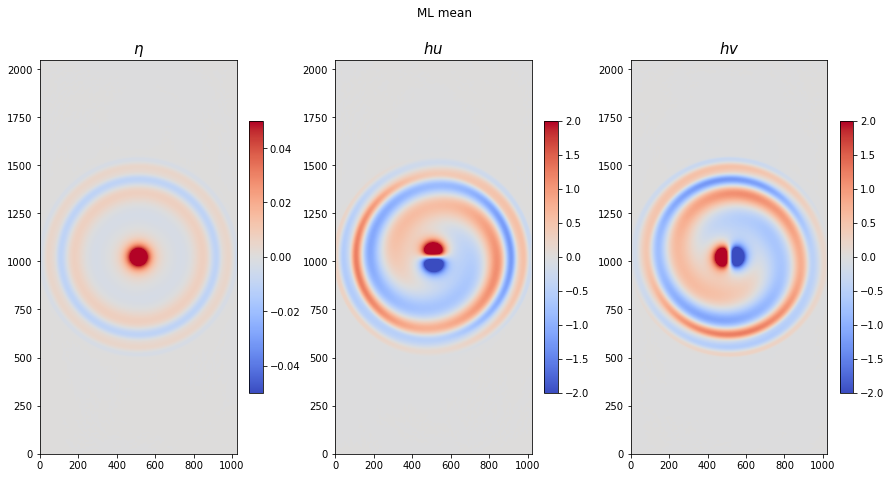

In [21]:
fig, axs = imshow3(MLmean(ML_state))
fig.suptitle("ML mean", y=0.85)

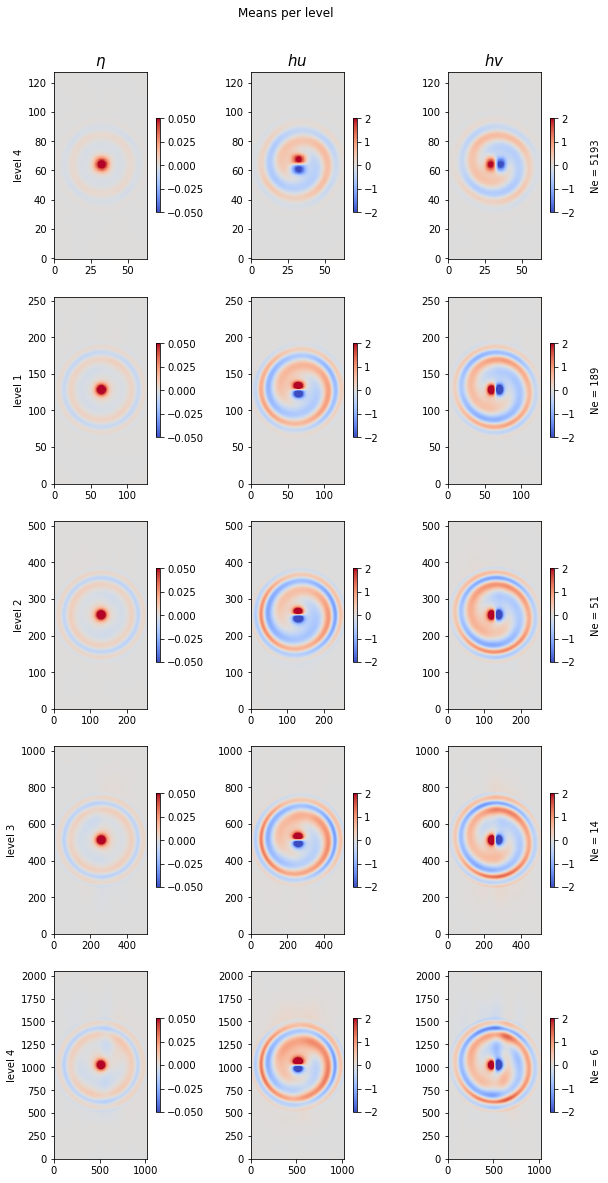

In [22]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Means per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.mean(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.mean(ML_state[l_idx][0],axis=-1)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

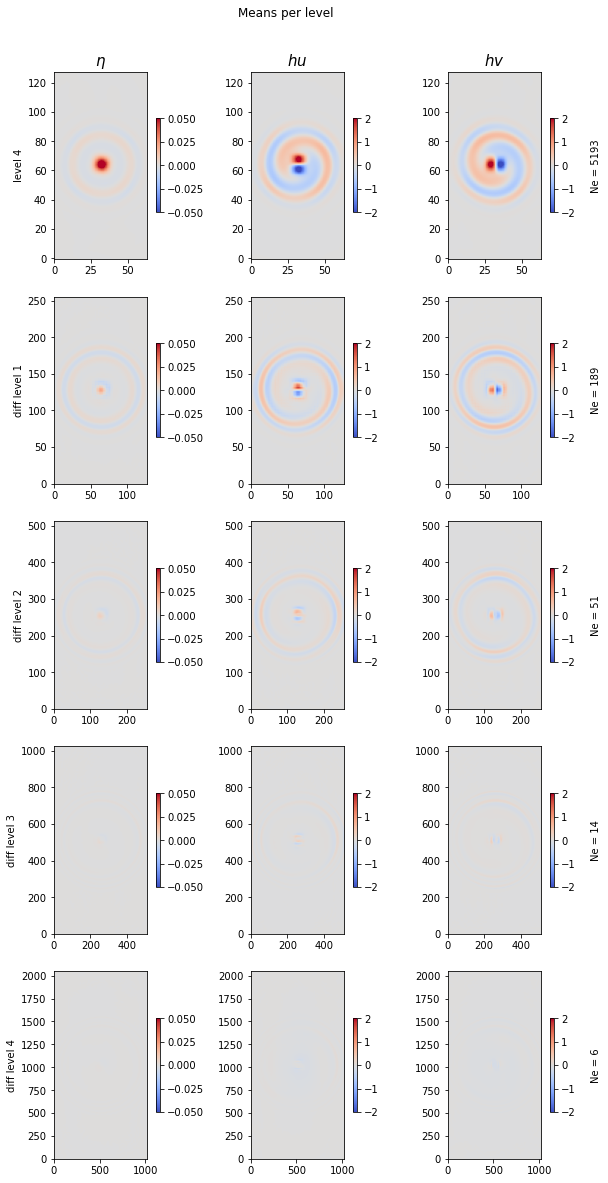

In [23]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Means per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.mean(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("diff level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.mean(ML_state[l_idx][0],axis=-1) - np.mean(ML_state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=-2, vmax=2, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

Analyse ML variance

In [24]:
def MLvar(state):
    MLest_var = np.zeros(state[-1][0].shape[:-1])
    MLest_var += np.var(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_var += (np.var(state[l_idx][0], axis=-1) - np.var(state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)
    
    return MLest_var

Text(0.5, 0.85, 'ML var')

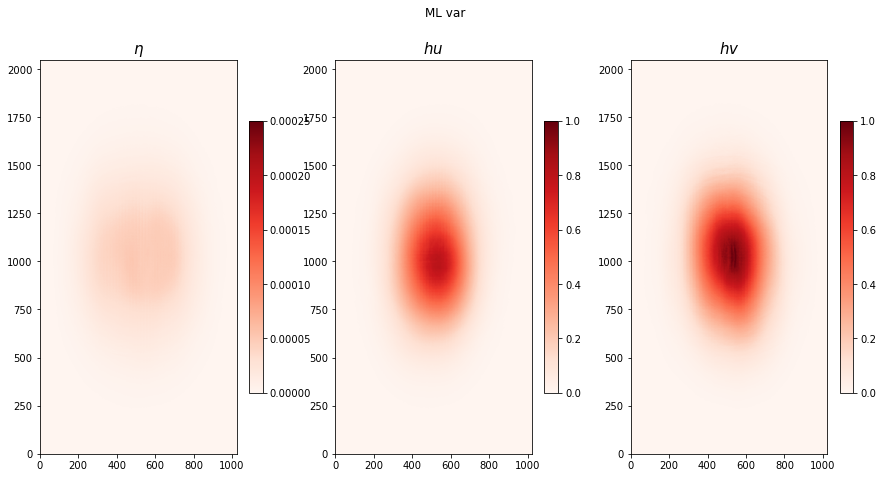

In [25]:
fig, axs = imshow3var(MLvar(ML_state))
fig.suptitle("ML var", y=0.85)

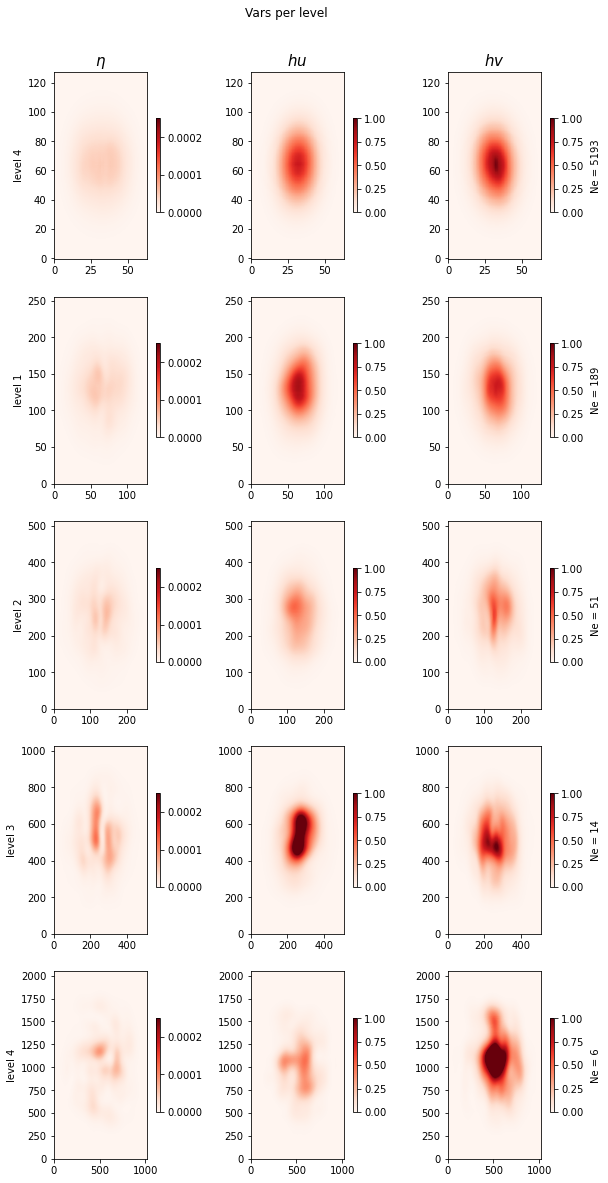

In [26]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Vars per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.var(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=0.0, vmax=0.00025, cmap="Reds")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=0, vmax=1, cmap="Reds")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=0, vmax=1, cmap="Reds")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.var(ML_state[l_idx][0],axis=-1)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=0.0, vmax=0.00025, cmap="Reds")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=0, vmax=1, cmap="Reds")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=0, vmax=1, cmap="Reds")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

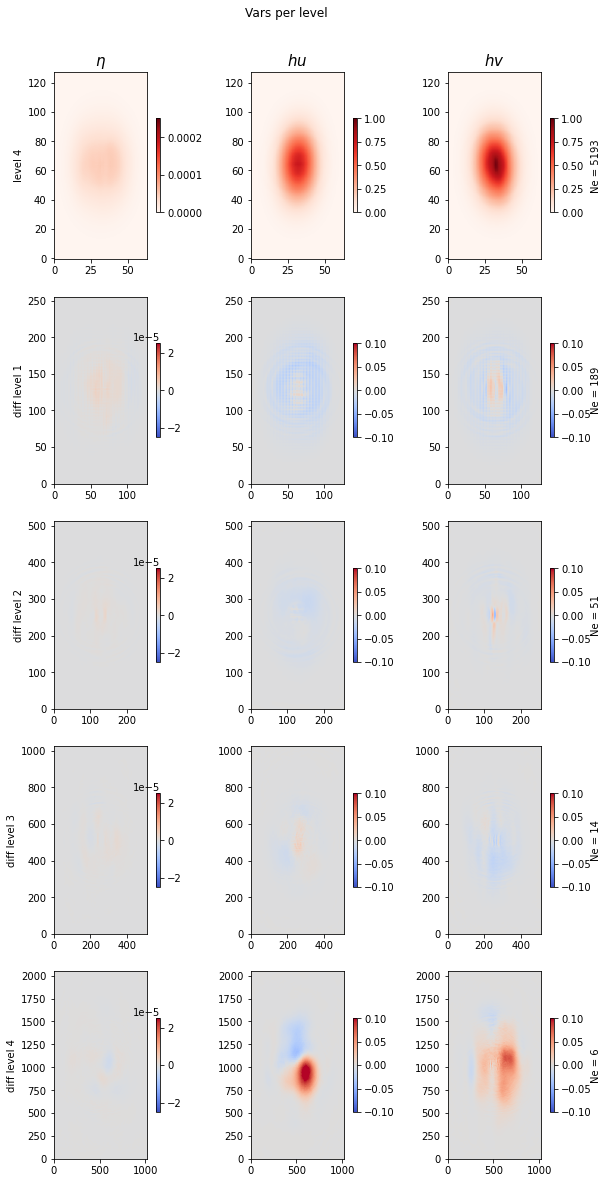

In [27]:
fig, axs = plt.subplots(len(ls), 3, figsize=(10,20))

fig.suptitle("Vars per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

axs[0,0].set_ylabel("level "+str(l_idx))
axs[0,2].yaxis.set_label_position("right")
axs[0,2].set_ylabel("Ne = "+str(ML_Nes[0]), labelpad = 50)

etahuhv = np.var(ML_state[0],axis=-1)
im = axs[0,0].imshow(etahuhv[0], vmin=0.0, vmax=0.00025, cmap="Reds")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title("$\eta$", fontsize=15)

im = axs[0,1].imshow(etahuhv[1], vmin=0, vmax=1, cmap="Reds")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title("$hu$", fontsize=15)

im = axs[0,2].imshow(etahuhv[2], vmin=0, vmax=1, cmap="Reds")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)
axs[0,2].set_title("$hv$", fontsize=15)

for l_idx in range(1,len(ls)):
    axs[l_idx,0].set_ylabel("diff level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]), labelpad = 50)

    etahuhv = np.var(ML_state[l_idx][0],axis=-1) - np.var(ML_state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)
    im = axs[l_idx,0].imshow(etahuhv[0], vmin=-0.000025, vmax=0.000025, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,0], shrink=0.5)

    im = axs[l_idx,1].imshow(etahuhv[1], vmin=-0.1, vmax=0.1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,1], shrink=0.5)

    im = axs[l_idx,2].imshow(etahuhv[2], vmin=-0.1, vmax=0.1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[l_idx,2], shrink=0.5)

Analyse ML rank histos 


WITHOUT OBSERVATION ERROR

In [28]:
def MLcdf4true(truth, Hx, Hy, ML_state, download=True):
    Nes = np.zeros(len(ML_state), dtype=np.int32)
    Nes[0] = ML_state[0].shape[-1]
    for l_idx in range(1,len(ML_state)):
        Nes[l_idx] = ML_state[l_idx][0].shape[-1]

    if download:
        true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
    else:
        true_eta, true_hu, true_hv = truth
    true_values = np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]]) #+ np.random.normal(0,R)

    Xs = np.linspace(0, nxs[-1] * dxs[-1], nxs[-1])
    Ys = np.linspace(0, nys[-1] * dys[-1], nys[-1])
    X, Y = np.meshgrid(Xs, Ys)

    lvl_Xs = np.linspace(0, nxs[0] * dxs[0], nxs[0])
    lvl_Ys = np.linspace(0, nys[0] * dys[0], nys[0])
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), ML_state[0][0].shape[:-1])

    ML_Fy = 1/Nes[0] * np.sum(ML_state[0][:,obs_idxs[0],obs_idxs[1],:] < true_values[:,np.newaxis], axis=1)

    for l_idx in range(1,len(ls)):
        lvl_Xs0 = np.linspace(0, nxs[l_idx] * dxs[l_idx], nxs[l_idx])
        lvl_Ys0 = np.linspace(0, nys[l_idx] * dys[l_idx], nys[l_idx])
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_Xs1 = np.linspace(0, nxs[l_idx-1] * dxs[l_idx-1], nxs[l_idx-1])
        lvl_Ys1 = np.linspace(0, nys[l_idx-1] * dys[l_idx-1], nys[l_idx-1])
        lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
        obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), ML_state[l_idx][1][0].shape[:-1])

        ML_Fy += 1/Nes[l_idx] * np.sum(1 * (ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1],:] < true_values[:,np.newaxis]) 
                                       - 1 * (ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1],:] < true_values[:,np.newaxis]), axis=1)
        
    return ML_Fy

In [29]:
# N = 1000
# true_values = np.zeros((N,3))
# for n in range(N):
#     print(n)
#     truth = generate_truth()
#     truth.step(T)
#     true_values[n] = np.array(truth.download(interior_domain_only=True))[:,Hy, Hx]

# np.save("dumpTrueValues",true_values)

In [30]:
# Load true values from disc (generation of 1000 samples takes 1h)
true_values = np.load("dumpTrueValues.npy")

Load from file with read-only option (generatiion takes 1h, and too big to load fully)

In [31]:
# N = 1000
# truthes = np.zeros((N,3,truth.ny,truth.nx))
# for n in range(N):
#     print(n)
#     truth = generate_truth()
#     truth.step(T)
#     truthes[n] = np.array(truth.download(interior_domain_only=True))
#     del truth

# np.save("dumpTruthes",truthes)

In [32]:
truthes = np.load("dumpTruthes.npy",  mmap_mode='r')

Diagonal comparison

In [91]:
fig, axs = plt.subplots(len(ls),3, figsize=(20,20))
fig.suptitle("Cut alont half of the diagonal",  y=0.9)

# levels
for l_idx in range(len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]))

    # level state
    if l_idx == 0:
        l_state = ML_state[0]
    else:
        l_state = ML_state[l_idx][0]


    # eta hu hv
    for v in range(3):
        if v == 0:
            axs[l_idx,v].set_ylim((-0.125,0.125))
        else:
            axs[l_idx,v].set_ylim((-10,10))

        # ensemble member
        for e in range(ML_Nes[l_idx]):
            axs[l_idx,v].plot( np.diag(l_state[v,(2**ls[l_idx])::2,(2**(ls[l_idx]-1))::1,e]).repeat(2**(ls[-1]-ls[l_idx])), alpha=np.maximum(10/ML_Nes[l_idx],0.01), c="C0", zorder=1)

        for diag_loc in range(50,500,50):
            loc_truthes = np.moveaxis(truthes,0,-1)[v,1024+2*diag_loc,512+diag_loc,:]
            low, mean, up = np.quantile(loc_truthes, 0.1), np.mean(loc_truthes),np.quantile(loc_truthes,0.9)
            axs[l_idx,v].scatter(diag_loc, mean, c="C1", marker="_", s=200, zorder=3)
            axs[l_idx,v].vlines(x=diag_loc, ymin=low, ymax=up, colors="C1", lw=2, zorder=2)
    

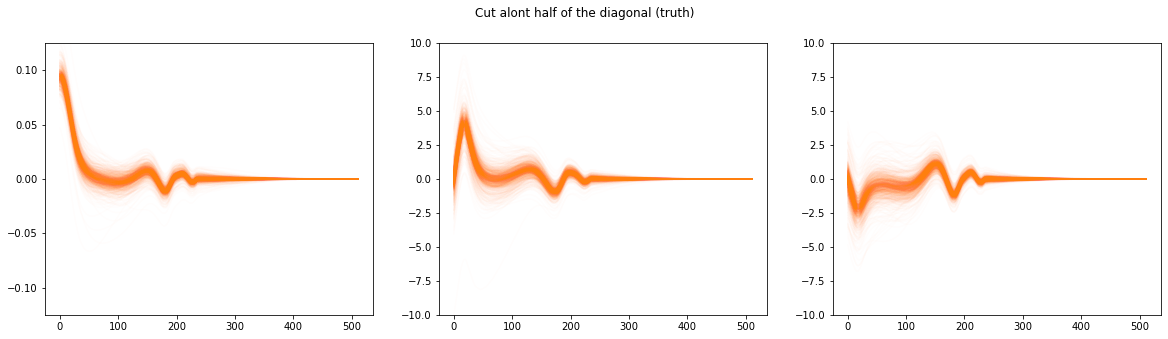

In [88]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
fig.suptitle("Cut alont half of the diagonal (1000 truthes)")

# eta hu hv
for v in range(3):
    if v == 0:
        axs[v].set_ylim((-0.125,0.125))
    else:
        axs[v].set_ylim((-10,10))

    # ensemble member
    for e in range(len(truthes)):
        axs[v].plot( np.diag(np.moveaxis(truthes,0,-1)[v,1024::2,512::1,e]), alpha=0.01, c="C1", zorder=1)

Use independent observation indices

In [59]:
newHx, newHy = nxs[-1]-Hx, nys[-1]-Hy

In [60]:
data_args = initLevel(ls[-1])
sim = CDKLM16.CDKLM16(gpu_ctx, **data_args)
sim.step(T)

125000.0

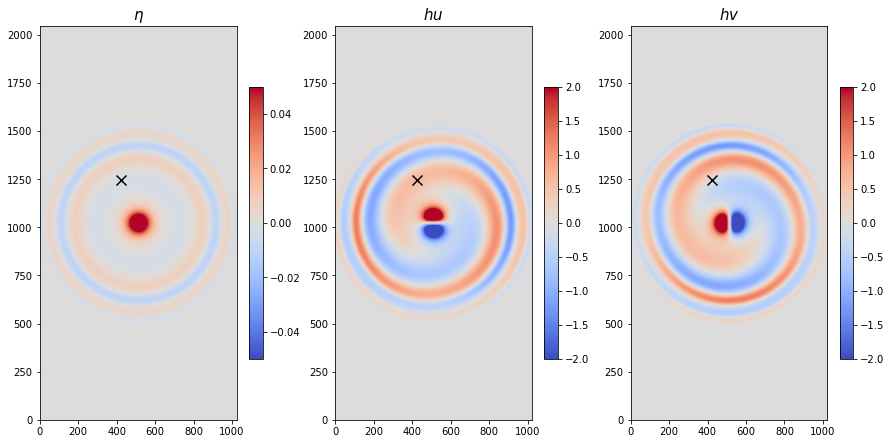

In [56]:
fig, axs = imshow3(np.array(sim.download(interior_domain_only=True)))
axs[0].scatter(newHy, newHx, marker="x", c="black", s=100)
axs[1].scatter(newHy, newHx, marker="x", c="black", s=100)
axs[2].scatter(newHy, newHx, marker="x", c="black", s=100)

ML rank histogram

In [57]:
ML_ranks = np.zeros((len(true_values),3))
for i in range(len(true_values)):
    ML_ranks[i] = MLcdf4true(truthes[i], newHx, newHy, ML_state, download=False)

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2282246/2661154013.py", line 3, in <module>
    ML_ranks[i] = MLcdf4true(truthes[i], newHx, newHy, ML_state, download=False)
  File "/tmp/ipykernel_2282246/1152805042.py", line 11, in MLcdf4true
    true_values = np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]]) #+ np.random.normal(0,R)
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/core/memmap.py", line 334, in __getitem__
    res = super().__getitem__(index)
IndexError: index 1248 is out of bounds for axis 1 with size 1024


IndexError: index 1248 is out of bounds for axis 1 with size 1024

Text(0.5, 1.0, 'hv')

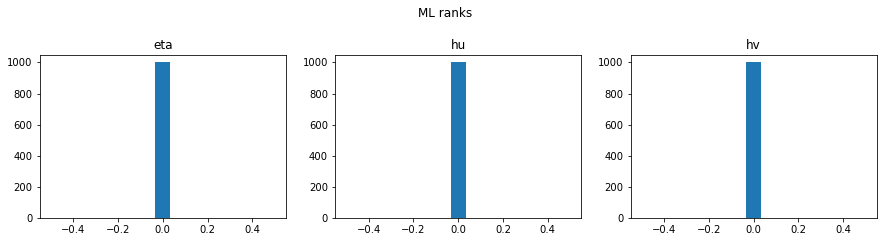

In [58]:

fig, axs = plt.subplots(1, 3, figsize=(15,3))
fig.suptitle("ML ranks",y=1.1)

for i in range(3):
    axs[i].hist(np.maximum(0,np.minimum(ML_ranks[:,i],1)), bins=15)

axs[0].set_title("eta")
axs[1].set_title("hu")
axs[2].set_title("hv")

Ranks per level

In [52]:
ranks_per_level = [] 

lvl_ranks = np.zeros((len(truthes),3))
for i in range(len(truthes)):

    Xs = np.linspace(0, nxs[-1] * dxs[-1], nxs[-1])
    Ys = np.linspace(0, nys[-1] * dys[-1], nys[-1])
    X, Y = np.meshgrid(Xs, Ys)

    lvl_Xs = np.linspace(0, nxs[0] * dxs[0], nxs[0])
    lvl_Ys = np.linspace(0, nys[0] * dys[0], nys[0])
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,newHx])**2 + (lvl_Y - Y[newHy,0])**2), ML_state[0][0].shape[:-1])

    lvl_ranks[i] = 1/ML_Nes[0] * np.sum(ML_state[0][:,obs_idxs[0],obs_idxs[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis], axis=1)
ranks_per_level.append(lvl_ranks)

for l_idx in range(1, len(ls)):
    lvl_ranks = np.zeros((len(true_values),3))
    for i in range(len(true_values)):
        lvl_Xs0 = np.linspace(0, nxs[l_idx] * dxs[l_idx], nxs[l_idx])
        lvl_Ys0 = np.linspace(0, nys[l_idx] * dys[l_idx], nys[l_idx])
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,newHx])**2 + (lvl_Y0 - Y[newHy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_ranks[i] = 1/ML_Nes[l_idx] * np.sum(ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis], axis=1)
    ranks_per_level.append(lvl_ranks)

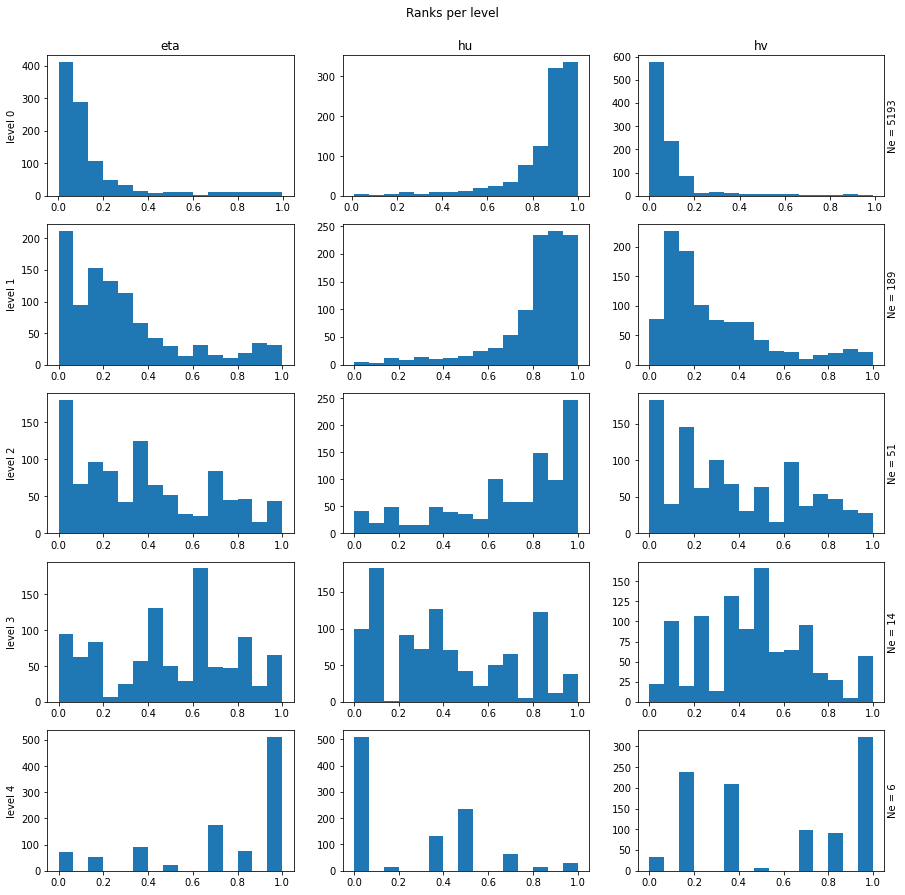

In [53]:
fig, axs = plt.subplots(len(ls), 3, figsize=(15,15))

fig.suptitle("Ranks per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

for l_idx in range(len(ls)):
    axs[l_idx,0].set_ylabel("level "+str(l_idx))
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]))
    for i in range(3):
        axs[l_idx,i].hist(np.maximum(0,np.minimum(ranks_per_level[l_idx][:,i],1)), bins=15)


Analysis

In [45]:
diff_ranks_per_level = np.zeros((len(ls),len(truthes),3))

for i in range(len(truthes)):

    Xs = np.linspace(0, nxs[-1] * dxs[-1], nxs[-1])
    Ys = np.linspace(0, nys[-1] * dys[-1], nys[-1])
    X, Y = np.meshgrid(Xs, Ys)

    lvl_Xs = np.linspace(0, nxs[0] * dxs[0], nxs[0])
    lvl_Ys = np.linspace(0, nys[0] * dys[0], nys[0])
    lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

    obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,newHx])**2 + (lvl_Y - Y[newHy,0])**2), ML_state[0][0].shape[:-1])

    diff_ranks_per_level[0][i] = 1/ML_Nes[0] * np.sum(ML_state[0][:,obs_idxs[0],obs_idxs[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis], axis=1)

for l_idx in range(1, len(ls)):
    lvl_ranks = np.zeros((len(true_values),3))
    for i in range(len(true_values)):
        lvl_Xs0 = np.linspace(0, nxs[l_idx] * dxs[l_idx], nxs[l_idx])
        lvl_Ys0 = np.linspace(0, nys[l_idx] * dys[l_idx], nys[l_idx])
        lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
        obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,newHx])**2 + (lvl_Y0 - Y[newHy,0])**2), ML_state[l_idx][0][0].shape[:-1])

        lvl_Xs1 = np.linspace(0, nxs[l_idx-1] * dxs[l_idx-1], nxs[l_idx-1])
        lvl_Ys1 = np.linspace(0, nys[l_idx-1] * dys[l_idx-1], nys[l_idx-1])
        lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
        obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,newHx])**2 + (lvl_Y1 - Y[newHy,0])**2), ML_state[l_idx][1][0].shape[:-1])

        diff_ranks_per_level[l_idx][i] = 1/ML_Nes[l_idx] * ( np.sum(1 * (ML_state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis]), axis=1) 
                                                            - np.sum(1 * (ML_state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1],:] < truthes[i,:,newHy,newHx][:,np.newaxis]), axis=1) )


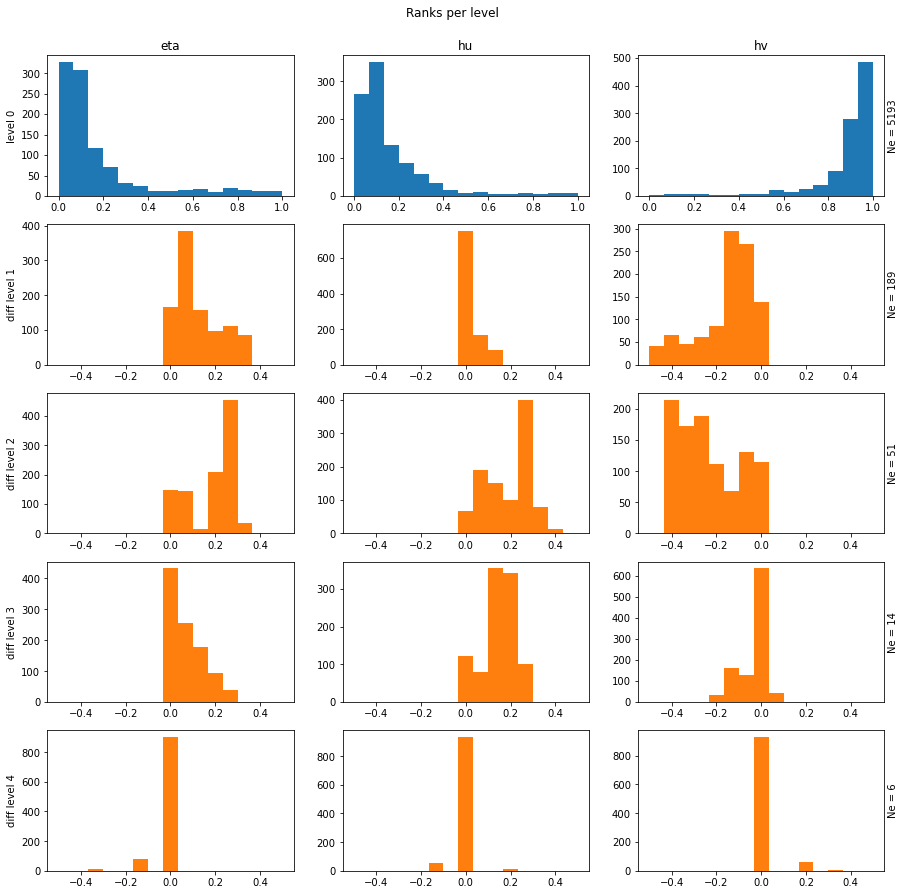

In [ ]:
fig, axs = plt.subplots(len(ls), 3, figsize=(15,15))

fig.suptitle("Ranks per level",y=0.925)

axs[0,0].set_title("eta")
axs[0,1].set_title("hu")
axs[0,2].set_title("hv")

for l_idx in range(len(ls)):
    if l_idx == 0:
        axs[l_idx,0].set_ylabel("level "+str(l_idx))
        bins = np.arange(0,1+1e-9,1/15)
        color="C0"
    else: 
        axs[l_idx,0].set_ylabel("diff level "+str(l_idx))
        bins = np.arange(-0.5,0.5+1e-9,1/15)
        color = "C1"
    axs[l_idx,2].yaxis.set_label_position("right")
    axs[l_idx,2].set_ylabel("Ne = "+str(ML_Nes[l_idx]))
    for i in range(3):
        hist = np.histogram(diff_ranks_per_level[l_idx][:,i], bins=bins)
        axs[l_idx,i].bar(0.5*(hist[1][1:]+hist[1][:-1]),hist[0], width=1/15, color=color)

    

In [ ]:
STOP

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2254814/2165152129.py", line 1, in <module>
    STOP
NameError: name 'STOP' is not defined


NameError: name 'STOP' is not defined

In [ ]:
# FEHLER!! NOT THE RIGHT QUANTITIES

# ranks_var = np.zeros((len(ls),3))
# for l_idx in range(len(ls)):
#     ranks_var[l_idx] = np.var(ranks_per_level[l_idx], axis=0)

# ranks_diff_var = np.zeros((len(ls)-1,3))
# for l_idx in range(1,len(ls)):
#     ranks_diff_var[l_idx-1] = np.var(diff_ranks_per_level[l_idx], axis=0)

# Nxs = (2**ls)*(2**(ls+1))
# fig, axs = plt.subplots(1,3, figsize=(15,5))
# for i in range(3):
#     axs[i].loglog(Nxs,ranks_var[:,i], label="Var[F(u^l)]")
#     axs[i].loglog(Nxs[1:],ranks_diff_var[:,i], label="Var[F(u^l+)-F(u^l-)]")
#     axs[i].legend()


In [16]:
NL = 250

# data_argsL = initLevel(ls[-1])

# stateL = np.zeros((3,nys[-1],nxs[-1],NL))
# for e in range(NL):
#     wind = wind_sample(KLSampler, T+T_forecast, wind_weight=wind_weight, wind_speed=0.0)
#     sim = CDKLM16.CDKLM16(gpu_ctx, **data_argsL, wind=wind)
#     sim.step(T)
#     stateL[:,:,:,e] = sim.download(interior_domain_only=True)
#     del sim

# np.save("dumpL.npy", stateL)

stateL = np.load("dumpL.npy")

In [19]:
ranksL = np.zeros((len(true_values),3))
for i in range(len(true_values)):
    ranksL[i] = 1/NL * np.sum(stateL[:,Hy,Hx,:] < true_values[i][:,np.newaxis], axis=1)

Text(0, 0.5, 'Ne = 250')

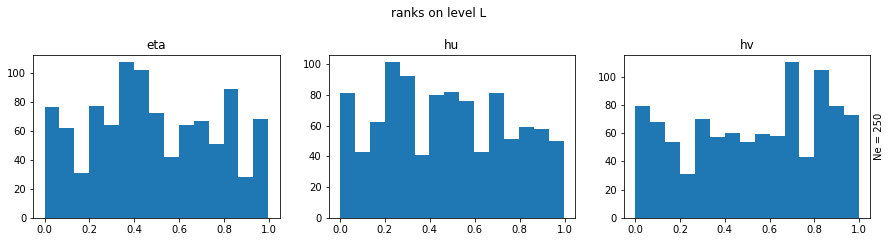

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))
fig.suptitle("ranks on level L",y=1.1)

for i in range(3):
    axs[i].hist(np.maximum(0,np.minimum(ranksL[:,i],1)), bins=15)

axs[0].set_title("eta")
axs[1].set_title("hu")
axs[2].set_title("hv")

axs[2].yaxis.set_label_position("right")
axs[2].set_ylabel("Ne = "+str(NL))


In [ ]:
STOP STOP STOP

CHECK SOME OBSERVATION ERROR NEXT! ...

NOW DO DATA ASSIMILATION AND CHECK RANKS AGAIN! ...

In [ ]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]]) 

In [ ]:
print(MLOceanEnsemble.estimate(np.mean)[:,Hy, Hx])
print(MLOceanEnsemble.estimate(np.var)[:,Hy, Hx])
np.array(MLOceanEnsemble.ML_ensemble[-1][0][0].download())[:,Hy,Hx], np.array(MLOceanEnsemble.ML_ensemble[-1][0][1].download())[:,Hy,Hx], np.array(MLOceanEnsemble.ML_ensemble[-1][0][2].download())[:,Hy,Hx]

In [ ]:
MLvar(MLOceanEnsemble.download())[:,Hy, Hx]

In [ ]:
Xs = np.linspace(0, ML_ensemble[-1][0][0].nx * ML_ensemble[-1][0][0].dx, ML_ensemble[-1][0][0].nx)
Ys = np.linspace(0, ML_ensemble[-1][0][0].ny * ML_ensemble[-1][0][0].dy, ML_ensemble[-1][0][0].ny)
X, Y = np.meshgrid(Xs, Ys)

lvl_Xs = np.linspace(0, ML_ensemble[0][0].nx * ML_ensemble[0][0].dx, ML_ensemble[0][0].nx)
lvl_Ys = np.linspace(0, ML_ensemble[0][0].ny * ML_ensemble[0][0].dy, ML_ensemble[0][0].ny)
lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), MLOceanEnsemble.download()[0][0].shape[:-1])

In [ ]:
np.var(MLOceanEnsemble.download()[0][:,obs_idxs[0],obs_idxs[1],:] , axis=1)

In [ ]:
np.var(MLOceanEnsemble.download()[0][:,obs_idxs[0],obs_idxs[1],:] , axis=1)

In [ ]:
def MLvar(state):
    MLest_var = np.zeros(state[-1][0].shape[:-1])
    MLest_var += np.var(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_var += (np.var(state[l_idx][0], axis=-1) - np.var(state[l_idx][1],axis=-1).repeat(2,1).repeat(2,2)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)
    
    return MLest_var


In [ ]:
MLOceanEnsemble.ML_ensemble[0][0].t

In [ ]:
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)
MLEnKF.assimilate(MLOceanEnsemble, obs, Hx, Hy, R, r = 2.5*1e7, relax_factor = 1.0)
imshow3(MLOceanEnsemble.estimate(np.mean))

In [ ]:
MLOceanEnsemble.step(T_forecast)
ML_final_state = MLOceanEnsemble.download()
imshow3(MLOceanEnsemble.estimate(np.mean))

In [ ]:
fig, axs = imshow3var(MLOceanEnsemble.estimate(np.var))
axs[0].scatter(Hy, Hx)
axs[1].scatter(Hy, Hx)
axs[2].scatter(Hy, Hx)

In [ ]:
truth.step(T_forecast)

ML_Fy = MLcdf4true(truth, Hx, Hy, ML_ensemble, ML_final_state)
ML_Fy

In [ ]:
def SLcdf4true(truth, Hx, Hy, SL_ensemble, SL_final_state):
    true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
    true_values = np.array([true_eta[Hy, Hx], true_hu[Hy, Hx], true_hv[Hy, Hx]])

    SL_Fy = np.sum(SL_final_state[:,Hy,Hx,:] < true_values[:,np.newaxis], axis=1)/SL_Ne    

    return SL_Fy

In [ ]:
SL_Fy = SLcdf4true(truth, Hx, Hy, SL_ensemble, SL_final_state)
SL_Fy